###  Key-finding algorithms: global key and local key detection


#### Task 2: Krumhansl-Schmuckler key-finding algorithm


* student: <br>
Tsu-Ching Hsiao / 103062372 <br>
<br>
* description: <br>
This file is the Task 2 of the 2018-spring MIR Homework 1 <br>
written in python 2 <br>
<br>
* dependencies: <br>
    * Numpy
    * Librosa



#### Q4 (25%): complete

In [1]:
# === hyper parameters ===

# dataset path
DATASET_PATH = './genres'
ANNOTATION_PATH = './gtzan_key/gtzan_key/genres'

In [2]:
# === import libraries ===
import numpy as np
import librosa.core
import librosa.display
import os
import math
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
# === utils from task 1 ===

# some default params
sampling_rate = 22050
mono = True

# read file
def readAUfile(filepath, silence=True):
    # read file
    y, sr = librosa.core.load(filepath, sampling_rate, mono)
    
    # display file info
    if not silence:
        print('File: {}'.format( os.path.abspath(filepath) ))
        print('Channels: {}'.format( 1 if mono==True else 2 ))
        print('Sampling freq: {} Hz'.format( sampling_rate ))
        print('Total samples: {}'.format( len(y) ))
    return y, sr

def nonlin_chroma(data, sr, gamma=1, chroma_type='stft'):
    if chroma_type == 'stft':
        return np.log(1+gamma*np.abs(librosa.feature.chroma_stft(y=data, sr=sr)))
    elif chroma_type == 'cens':
        return np.log(1+gamma*np.abs(librosa.feature.chroma_cens(y=data, sr=sr)))
    elif chroma_type == 'cqt':
        return np.log(1+gamma*np.abs(librosa.feature.chroma_cqt(y=data, sr=sr)))
    
def gen_chord_name():
    major = ['A', 'A#', 'B', 'C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#']
    minor = ['a', 'a#', 'b', 'c', 'c#', 'd', 'd#', 'e', 'f', 'f#', 'g', 'g#']
    return major + minor

# Generate chord template
def gen_all_template():
    template = []
    
    # Krumhansl-Schmuckler's template
    major_t = [6.35, 2.23, 3.48, 2.33, 4.38, 4.09, 2.52, 5.19, 2.39, 3.66, 2.29, 2.88]
    minor_t = [6.33, 2.68, 3.52, 5.38, 2.60, 3.53, 2.54, 4.75, 3.98, 2.69, 3.34, 3.17]

    def circular_shift(x, sh):
        return x[sh:]+x[:sh]

    # major
    for i in range(3, -9, -1):
        template.append(circular_shift(major_t, i))

    # minor
    for i in range(3, -9, -1):
        template.append(circular_shift(minor_t, i))

    template = np.asarray(template, dtype='float')
    return template

def gen_template(tonic):
    major_t = [6.35, 2.23, 3.48, 2.33, 4.38, 4.09, 2.52, 5.19, 2.39, 3.66, 2.29, 2.88]
    minor_t = [6.33, 2.68, 3.52, 5.38, 2.60, 3.53, 2.54, 4.75, 3.98, 2.69, 3.34, 3.17]
    
    def circular_shift(x, sh):
        return x[sh:]+x[:sh]
    
    template = [circular_shift(major_t, -tonic), circular_shift(minor_t, -tonic)]
    return np.asarray(template, dtype='float')

def correlation_coef(chroma_vector, template):
    sum_chroma = chroma_vector
    
    mean_x = np.mean(sum_chroma)
    mean_y = np.mean(template, axis=1)
    
    X = sum_chroma-mean_x
    Y = template-mean_y[:, None]
    
    coef = np.sum( X*Y, axis=1 ) / np.sqrt( np.sum(X**2)*np.sum(Y**2, axis=1) )
    return coef

def get_genre_filelist(genre):
    path = os.path.join(DATASET_PATH, genre)
    files = sorted([ os.path.join(path, f) for f in os.listdir(path) ])
    return files
    
def get_genre_anno(genre):
    path = os.path.join(ANNOTATION_PATH, genre)
    files = sorted([ os.path.join(path, f) for f in os.listdir(path) ])
    anno = []
    for fp in files:
        with open(fp, 'r') as f:
            anno.append( int(f.read()) )
    return anno

In [4]:
testing_genres = ['pop', 'blues', 'metal', 'hiphop', 'rock']

def eval_once(gamma, chroma_type='stft', similarity=correlation_coef, silence=True):
    genre_eval_table = []
    genre_predict_label = []
    
    # generate template
    chord = gen_chord_name()
    
    # for each genres
    for genre in testing_genres:
        # create eval table
        eval_table = np.zeros((24, 24), dtype='int')  # (answer, eval)
        predict_label = []
        # get list
        path_list = get_genre_filelist(genre)
        anno_list = get_genre_anno(genre)
    
        for path, anno in zip(path_list, anno_list):
            # skip unknown annotation
            if anno == -1:
                continue
            if not silence:
                print('Working on: ', path)
            
            # read audio file
            data, sr = readAUfile(path)
            
            # create non-linear chromagram
            chroma = nonlin_chroma(data, sr, gamma, chroma_type)
            chroma_vec = np.sum(chroma, axis=1)
            
            # predict
            template = gen_all_template()
            r = np.argmax( similarity(chroma_vec, template) )
            
            eval_table[anno, r] += 1
            predict_label.append( [os.path.basename(path).rsplit('.au', 1)[0], r] )
            if not silence:
                print('  Label: {} / predict: {}'.format(chord[anno], chord[r]))
                
        genre_eval_table.append(eval_table)
        genre_predict_label.append(predict_label)
    return genre_eval_table, genre_predict_label

In [5]:
def draw_table(table, genre):
    axis_font = {'size':'16'}
    label_font = {'size': '20'}
    fig, ax = plt.subplots(figsize=(10,10))
    max_val = table.max
    min_val = table.min
    
    ax.matshow(table, cmap=plt.cm.Blues)
    ax.xaxis.set_ticks(np.arange(0, 24, 1))
    ax.yaxis.set_ticks(np.arange(0, 24, 1))
    chord = gen_chord_name()
    ax.set_xticklabels(chord)
    ax.set_yticklabels(chord)
    
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(16)
        
    ax.set_ylabel('Answer', **label_font)
    ax.set_xlabel('Predict', **label_font)
    
    
    
    for i in range(24):
        for j in range(24):
            c = table[j, i]
            ax.text(i, j, str(c), va='center', ha='center', **axis_font)
            ax.set_title(genre, **label_font)
            
def output_label(filename, labels):
    with open(filename, 'w') as f:
        for label in labels:
            for l in label:
                f.write('{}\t{}\n'.format(l[0], l[1]))
                
def accuracy(tables):
    total_test = 0
    total_acc = 0
    acc_list = []
    for table in tables:
        acc = float(np.trace(table))
        total = float(np.sum(table))
        acc_list.append(acc/total)
        
        # append to total
        total_test = total_test + total
        total_acc = total_acc + acc
    
    return total_acc/total_test, acc_list

def new_accuracy(tables):
    total_test = 0
    total_acc = 0
    acc_list = []
    for table in tables:
        acc = 0
        acc += float(np.trace(table))
        for c in range(24):
            fif = (c+7)%12 + c//12*12
            rel = (c+9)%12 + (1-c//12)*12
            par = (c+12)%24
            acc += 0.5 * float(table[c][fif])
            acc += 0.3 * float(table[c][rel])
            acc += 0.2 * float(table[c][par])
        total = float(np.sum(table))
        acc_list.append(acc/total)
        
        # append to total
        total_test = total_test + total
        total_acc = total_acc + acc
    
    return total_acc/total_test, acc_list

===============================

#### Q4: Evaluate

In [6]:
gamma = [1, 10, 100, 1000]
q4_tables = []
q4_labels = []

for g in gamma:
    table, label = eval_once(g)
    output_label('Q4_{}'.format(g), label)
    q4_tables.append(table)
    q4_labels.append(label)
    acc, l = accuracy(table)
    print(' ===== gamma = {} ===== '.format(g))
    print('Total Accuracy: ', acc)
    print('each genre: ')
    for i in range(len(testing_genres)):
        print('  {}: {}'.format(testing_genres[i], l[i]))

 ===== gamma = 1 ===== 
Total Accuracy:  0.33836206896551724
each genre: 
  pop: 0.5638297872340425
  blues: 0.1836734693877551
  metal: 0.3333333333333333
  hiphop: 0.1728395061728395
  rock: 0.41836734693877553
 ===== gamma = 10 ===== 
Total Accuracy:  0.32112068965517243
each genre: 
  pop: 0.5425531914893617
  blues: 0.19387755102040816
  metal: 0.27956989247311825
  hiphop: 0.1728395061728395
  rock: 0.3979591836734694
 ===== gamma = 100 ===== 
Total Accuracy:  0.3146551724137931
each genre: 
  pop: 0.5425531914893617
  blues: 0.20408163265306123
  metal: 0.27956989247311825
  hiphop: 0.1728395061728395
  rock: 0.35714285714285715
 ===== gamma = 1000 ===== 
Total Accuracy:  0.3081896551724138
each genre: 
  pop: 0.5425531914893617
  blues: 0.20408163265306123
  metal: 0.25806451612903225
  hiphop: 0.1728395061728395
  rock: 0.3469387755102041


##### Result 1 (Same)
|Gamma|Accuracy|
|-|-|
|1|33.83%|
|10|32.11%|
|100|31.46%|
|1000|30.81%|

In [7]:
for g, table in zip(gamma, q4_tables):
    acc, l = new_accuracy(table)
    print(' ===== gamma = {} ===== '.format(g))
    print('Total Accuracy: ', acc)
    print('each genre: ')
    for i in range(len(testing_genres)):
        print('  {}: {}'.format(testing_genres[i], l[i]))

 ===== gamma = 1 ===== 
Total Accuracy:  0.45021551724137937
each genre: 
  pop: 0.6606382978723404
  blues: 0.286734693877551
  metal: 0.45053763440860223
  hiphop: 0.27160493827160487
  rock: 0.5591836734693878
 ===== gamma = 10 ===== 
Total Accuracy:  0.4280172413793104
each genre: 
  pop: 0.6436170212765958
  blues: 0.28469387755102044
  metal: 0.38064516129032266
  hiphop: 0.2530864197530863
  rock: 0.5540816326530613
 ===== gamma = 100 ===== 
Total Accuracy:  0.41271551724137934
each genre: 
  pop: 0.6212765957446809
  blues: 0.28469387755102044
  metal: 0.37634408602150543
  hiphop: 0.2506172839506172
  rock: 0.5091836734693879
 ===== gamma = 1000 ===== 
Total Accuracy:  0.4058189655172414
each genre: 
  pop: 0.6265957446808511
  blues: 0.28061224489795916
  metal: 0.34946236559139787
  hiphop: 0.2530864197530864
  rock: 0.49897959183673485


#### Result 2 (fifth, relative, parallel M/m)
|Gamma|Accuracy|
|-|-|
|1|45.02%|
|10|42.80%|
|100|41.27%|
|1000|40.58%|

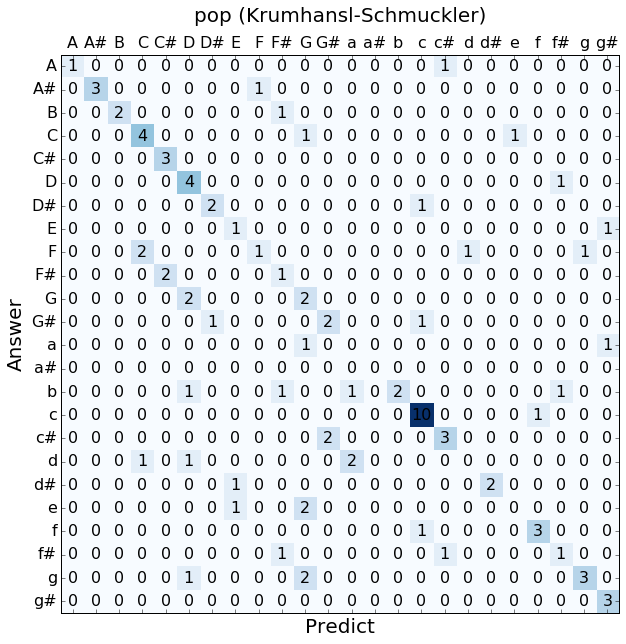

In [8]:
draw_table(q4_tables[0][0], 'pop (Krumhansl-Schmuckler)')

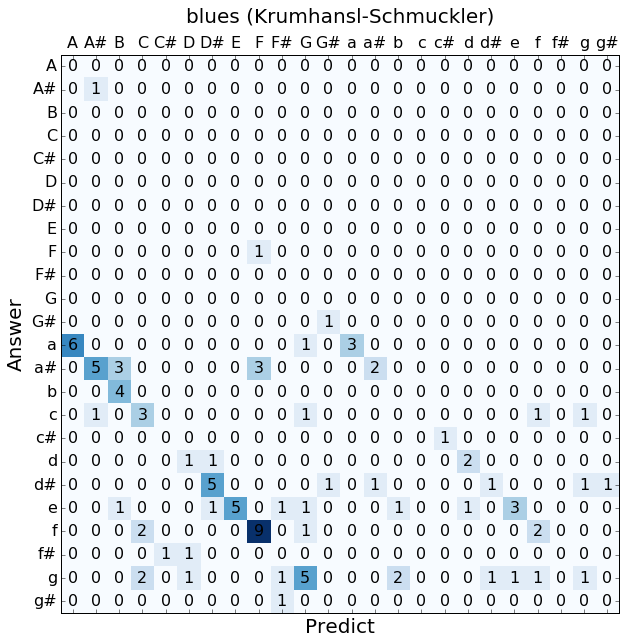

In [9]:
draw_table(q4_tables[0][1], 'blues (Krumhansl-Schmuckler)')

#### Q4: Discussion
We can see that the biggest difference between Task2 and Task1 is that the 'blues' genre of the task2 hit more answers than task1. That's becase Krumhansl-Schmuckler use 'Weighted' template to detect the key, which will enhence the feature differences between major key and minor key. So the 'Parallel major/miner' relations decreased and the right answer increased.
<br><br>
The point of major/minor feature enhencement of Krumhansl-Schmuckler's template is that Krumhansl-Schmuckler intuitively increased the weight of 'mediant key', which is an important feature to distinguish whether a song is in major key or minor key.

===============================
#### Q5 (20%):
* Question: What is the limitation of these two methods in key detection?
* Answer: There are two limitations of these two methods:
    1. When we use these methods, we assume that the tonic pitch will appear most frequently. This will result in serious problems if the song use other pitches more than tonic pitch. 
        * The following example 1 is definitely violated to our assumption. The maximal value in the chroma vector is key G, in contrasts, the minimal value is key E. However, the key E  IS  the tonic pitch of this song. In this case, we misjudgement the tonic pitch in the first stage, not to mention to find out the major/minor key of this song.

        * Another example 2 shows that 'blues' songs often use some tricks, for example, swiching between major and minor key in the middle of the song with the same tonic. This will seriously fustrate our detection performance. Even if we detected that the major mediant is more than minor mediant, the song might still be in minor key. Actually, these cases are vary difficult to distinguish even for humans.
        
    2. Another limitation is that summing up chromagram will destroy the over time changes of the features, so this method can not be used to detect local key.
<br><br>
* for example 1

|Key |C |C#|D|D#|E|F|F#|G|G#|A|A#|B|
|----|--|-|-|-|-|-|-|--|-|-|-|-|
|Freq|10|7|4|1|0|5|9|11|8|2|3|6|

(the higher frequency which means the more the key appeared)

<br>
* Question: Is there any drawback of using the GTZAN dataset for key detection?
* Answer: Yes there is. In my opinion, 30 seconds is enough to detect the key of a song, except for those "striving for innovation" songs. I mean those songs used less tonic pitch.

<br>
* Question: Please design an algorithm that outperforms the two algorithms
* Answer: I tested several methods to overcome those problems I mentioned above. Instead of using correlation coefficient as my similarity measurement, I use l2-norm (also known as euclidean distance), l1-norm (also known as manhattan distance), and l2-norm, coefficient hybrid method (I called l2-coef) to measure the similarity between chroma vector and Krumhansl-Schmuckler's profile. 
    * For total accuracy, L2-coef method with rate 0.8 performed the best. We can get higher total accuracy than correlation coefficient. 
    * For 'blues', 'metal' and 'hiphop', L2-norm method highly outperformed than correlation coefficient. 
<br><br>
The table below shows the top accuracy for each method and each genre.

|Method|Total accuracy|pop|Blues|Matel|Hiphop|Rock|
|------|--------------|---|-----|-----|------|----|
|correlation coefficient|45.02%|66.06%|28.67%|45.05%|27.16%|55.91%|
|L2-norm|45.90%|48.19%|52.44%|57.54%|34.93%|35.00%|
|L1-norm|10.75%|8.72%|12.95%|14.73%|5.92%|10.71%|
|L2-coef hybrid (rate=0.7)|48.79%|54.68%|47.04%|57.95%|34.93%|47.65%|
|L2-coef hybrid (rate=0.8)|49.20%|59.46%|41.32%|56.23%|32.96%|53.97%|
|L2-coef hybrid (rate=0.9)|49.13%|65.53%|35.81%|53.01%|30.74%|58.26%|


Chromagram size:  (12, 1293)
Ranks:  [10  7  4  1  0  5  9 11  8  2  3  6]


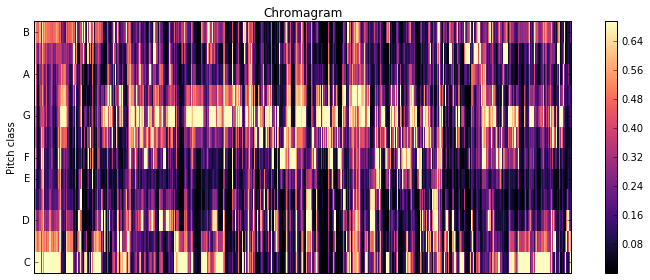

In [15]:
# Example 1

data, sr = readAUfile(os.path.join(DATASET_PATH, 'blues/blues.00001.au'))

# create chromagram
chroma1 = nonlin_chroma(data, sr, 1)
print('Chromagram size: ', chroma1.shape)
chroma_vec = np.sum(chroma1, axis=1)
temp = chroma_vec.argsort()
ranks = np.empty_like(temp)
ranks[temp] = np.arange(len(chroma_vec))
print('Ranks: ', ranks)

# plot chromagram
plt.figure(figsize=(10, 4))
librosa.display.specshow(chroma1, y_axis='chroma')
plt.colorbar()
plt.title('Chromagram')
plt.tight_layout()

Chromagram size:  (12, 1293)
Ranks:  [ 4  7  2  5 10  6  0  1  8 11  9  3]


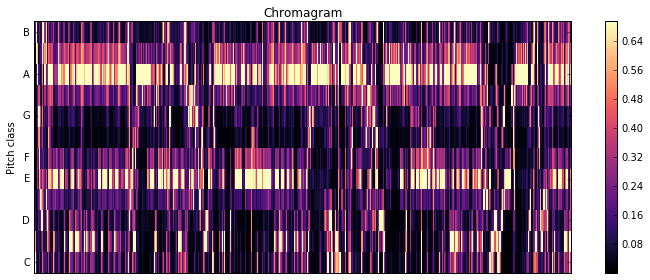

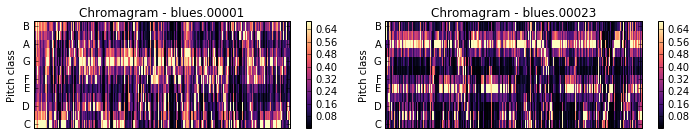

In [21]:
# Example 2

data, sr = readAUfile(os.path.join(DATASET_PATH, 'blues/blues.00023.au'))

# create chromagram
chroma2 = nonlin_chroma(data, sr, 1)
print('Chromagram size: ', chroma2.shape)
chroma_vec = np.sum(chroma2, axis=1)
temp = chroma_vec.argsort()
ranks = np.empty_like(temp)
ranks[temp] = np.arange(len(chroma_vec))
print('Ranks: ', ranks)

# plot chromagram
plt.figure(figsize=(10, 4))
librosa.display.specshow(chroma2, y_axis='chroma')
plt.colorbar()
plt.title('Chromagram')
plt.tight_layout()

plt.figure(figsize=(10, 2))
plt.subplot(1, 2, 1)
librosa.display.specshow(chroma1, y_axis='chroma')
plt.colorbar()
plt.title('Chromagram - blues.00001')

plt.subplot(1, 2, 2)
librosa.display.specshow(chroma2, y_axis='chroma')
plt.colorbar()
plt.title('Chromagram - blues.00023')
plt.tight_layout()

In [12]:
def l2_norm(chroma_vector, template):
    sub = template - chroma_vector[None, :]
    return -np.abs((sub*sub).sum(axis=1))

def l1_norm(chroma_vector, template):
    sub = template - chroma_vector[None, :]
    return -(np.abs(sub).sum(axis=1))

def normalize(mat):
    mx = mat.max()
    mn = mat.min()
    return (mat-mn)/(mx - mn)
    
def half_coef_l2(chroma_vector, template, rate=0.8):
    l2 = normalize(l2_norm(chroma_vector, template))
    coef = normalize(correlation_coef(chroma_vector, template))
    return coef*rate + l2*(1-rate)

##### Q5: L2 norm, L1 norm, l2-coef hybrid

In [13]:
gamma = 1
q5_tables = []
q5_labels = []

methods = [l2_norm, l1_norm, half_coef_l2]

for method in methods:
    table, label = eval_once(gamma, similarity=method)
    output_label('Q5_{}'.format(gamma), label)
    q5_tables.append(table)
    q5_labels.append(label)
    acc, l = new_accuracy(table)
    print(' ===== method = {} ===== '.format(method.__name__))
    print('Total Accuracy: ', acc)
    print('each genre: ')
    for i in range(len(testing_genres)):
        print('  {}: {}'.format(testing_genres[i], l[i]))

 ===== method = l2_norm ===== 
Total Accuracy:  0.45905172413793116
each genre: 
  pop: 0.48191489361702133
  blues: 0.5244897959183674
  metal: 0.5774193548387097
  hiphop: 0.3493827160493827
  rock: 0.35
 ===== method = l1_norm ===== 
Total Accuracy:  0.10754310344827585
each genre: 
  pop: 0.08723404255319148
  blues: 0.12959183673469388
  metal: 0.14731182795698924
  hiphop: 0.059259259259259255
  rock: 0.10714285714285714
 ===== method = half_coef_l2 ===== 
Total Accuracy:  0.49202586206896554
each genre: 
  pop: 0.5946808510638297
  blues: 0.41326530612244905
  metal: 0.5623655913978496
  hiphop: 0.3296296296296296
  rock: 0.539795918367347


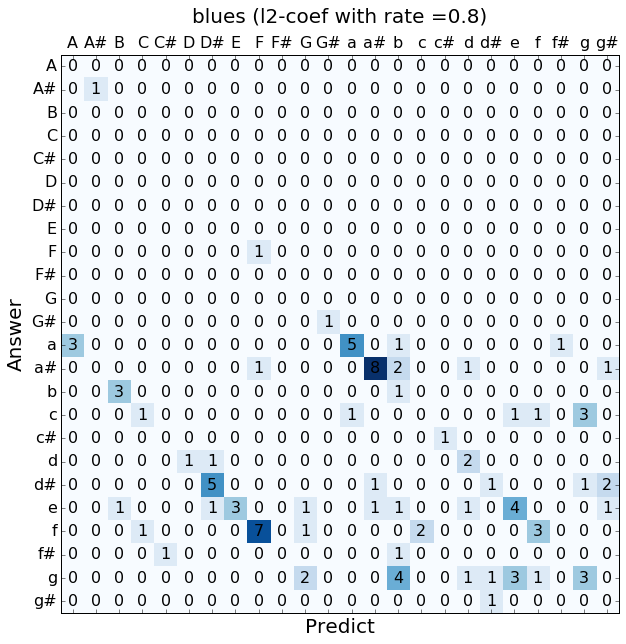

In [14]:
draw_table(q5_tables[2][1], 'blues (l2-coef with rate =0.8)')